#### Problem 1: Show that the innovations $\nu_t = Y_t - \mathbb{E}[X_t|Y_{1:t-1}]$ in the local level model are mutually independent for different values of $t$.

The local level model specified as follows:  

$$
X_{t+1} = X_{t} + \epsilon_{t} \\
Y_{t} = X_{t} + \eta_{t}
$$
for $t = 1,2,...$ where $\epsilon_{t} \sim N(0,\sigma_{\epsilon}^2)$, and $\eta_{t} \sim N(0,\sigma_{\eta}^2)$. All the $\epsilon_{t}$ and $\eta_{t}$ are assumed mutually independent.

According to the assumptions of local level model that the sources of randomness are Gaussian and the distribution of the initial value $X_{1}$ is also known and Gaussian, and thus we only need to prove that $cov(\nu_t,\nu_s) = \mathbb{E}[\nu_t \, \nu_s] - \mathbb{E}[\nu_t]\,\mathbb{E}[\nu_s] = 0$ for any $s \neq t$.

Wlog, let $s \le t$
- Prove $\mathbb{E}[\nu_t] =0$  

$$
\mathbb{E}[\nu_t] = \mathbb{E}[\mathbb{E}[(Y_t - \mu_t)|Y_{1:t-1}]]=\mathbb{E}[\mathbb{E}[Y_t - \mathbb{E}[X_t|Y_{1:t-1}]]|Y_{1:t-1}]=\mathbb{E}[\mathbb{E}[Y_t|Y_{1:t-1}]-\mathbb{E}[X_t|Y_{1:t-1}]]=0
$$

- Prove $\mathbb{E}[\nu_t \, Y_s] = 0$              
  From i) we know that $\mathbb{E}[\nu_t|Y_{1:t-1}]=0$

$$
\mathbb{E}[\nu_t \, Y_s]=\mathbb{E}[\mathbb{E}[(\nu_t \, Y_s)|Y_{1:t-1}]]=\mathbb{E}[Y_s \, \mathbb{E}[\nu_t|Y_{1:t-1}]]=0 
$$

- Prove $\mathbb{E}[\mu_s \, \nu_t]=0$
  From i) we know that $\mathbb{E}[\nu_t|Y_{1:t-1}]=0$
  
$$
\mathbb{E}[\mu_s \, \nu_t]=\mathbb{E}[\mathbb{E}[\mu_s \, \nu_t]|Y_{1:t-1}]=\mathbb{E}[\mu_s \, \mathbb{E}[\nu_t|Y_{1:t-1}]]=0
$$

Then
$$
cov(\nu_t,\nu_s) = \mathbb{E}[\nu_t \, \nu_s] - \mathbb{E}[\nu_t]\,\mathbb{E}[\nu_s]
=\mathbb{E}[\nu_t \, (Y_s-\mu_s)]=\mathbb{E}[\nu_t \, Y_s] - \mathbb{E}[\nu_t \, \mu_s]=0
$$

Thus we can say the innovations in the local level model are mutually independent for different values of $t$.

#### Problem 2: Kalman filter

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
import matplotlib.pyplot as plt
from datetime import datetime
from pykalman import KalmanFilter

In [2]:
# read data
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
SPX = pd.read_csv('SPX.csv', parse_dates=['Date'], date_parser=dateparse)
AAPL = pd.read_csv('AAPL.csv', parse_dates=['Date'],date_parser=dateparse)
data = pd.merge(SPX, AAPL, how = 'inner', on = 'Date')
# calculate the return
data['AAPL_ret'] = data['AAPL US Equity'].pct_change()
data['SPX_ret'] = data['SPX Index'].pct_change()
data = data.dropna()

##### Visualize the data

In [3]:
data.head()

,Date,SPX Index,AAPL US Equity,AAPL_ret,SPX_ret
1,2012-03-17,1404.17,75.8662,0.000000,0.000000
2,2012-03-18,1404.17,75.8662,0.000000,0.000000
3,2012-03-19,1409.75,77.8782,0.026520,0.003974
4,2012-03-20,1405.52,78.5079,0.008086,-0.003001
5,2012-03-21,1402.89,78.0596,-0.005710,-0.001871


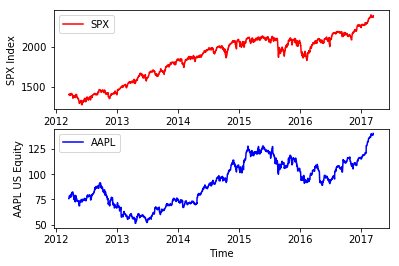

In [4]:
plt.subplot(211)
plt.plot(data['Date'],data['SPX Index'],'r-',label='SPX')
plt.xlabel('Time')
plt.ylabel('SPX Index')
plt.legend()
plt.subplot(212)
plt.plot(data['Date'],data['AAPL US Equity'],'b-',label='AAPL')
plt.xlabel('Time')
plt.ylabel('AAPL US Equity')
plt.legend()
plt.show()

##### Kalamn Filter
From the problem
$$
X_{t+1} = X_{t} + \epsilon_{t+1} \\
Y_t = X_t + \mu_t
$$
where $X_t = \alpha_t \,;\,Y_t = r_t - \beta_t \, m_t$

Step 1: Linear regression to get betas and alphas (63 days as rolling window).

In [5]:
alpha, beta, time =[],[],[]
index_start, index_end = 0,0
time_end = data['Date'][len(data['Date'])-1]

for t in data['Date']:
    time_tmp = t + timedelta(days=63)
    if time_tmp <= time_end:
        time.append(time_tmp)
        index_end = pd.Index(data['Date']).get_loc(time_tmp)
        y_tmp = data['AAPL_ret'][index_start:index_end]
        x_tmp = data['SPX_ret'][index_start:index_end]
        index_start += 1
        slope, intercept, r_value, p_value, std_err = stats.linregress(x=x_tmp,y=y_tmp)
        alpha.append(intercept)
        beta.append(slope)

data_tmp = pd.DataFrame({'Date': time, 'alpha': alpha,'beta': beta})
data_new = pd.merge(data, data_tmp, how = 'inner', on = 'Date')
data_new['Y_t'] = data_new['AAPL_ret']-data_new['beta']*data_new['SPX_ret']

In [6]:
data_new.head()

,Date,SPX Index,AAPL US Equity,AAPL_ret,SPX_ret,alpha,beta,Y_t
0,2012-05-19,1295.22,68.7158,0.000000,0.000000,0.000548,1.545480,0.000000
1,2012-05-20,1295.22,68.7158,0.000000,0.000000,0.000548,1.545480,0.000000
2,2012-05-21,1315.99,72.7192,0.058260,0.016036,0.000548,1.545480,0.033477
3,2012-05-22,1316.63,72.1608,-0.007679,0.000486,0.000920,1.698652,-0.008505
4,2012-05-23,1318.86,73.9215,0.024400,0.001694,0.000579,1.702044,0.021517


Step 2: Apply it in kalman filter

In [7]:
kf = KalmanFilter(
                  transition_matrices=[1],
                  observation_matrices=[1],
                  transition_offsets=[0],
                  observation_offsets=[0],
                  )
kf = kf.em(data_new['Y_t'],n_iter=500,em_vars=['transition_covariance', 'observation_covariance',
                                   'initial_state_mean', 'initial_state_covariance'] )
# Use the observed values of the price to get a rolling mean
state_means, filtered_state_covariances = kf.filter(data_new['Y_t'])
smoothed_state_means, smoothed_filtered_state_covariances = kf.smooth(data_new['Y_t'])

Step 3: Plot the observed values and filtered values

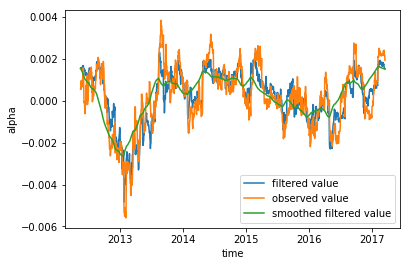

In [8]:
plt.plot(data_new['Date'],state_means,label="filtered value")
plt.plot(data_new['Date'],data_new['alpha'],label="observed value")
plt.plot(data_new['Date'],smoothed_state_means,label="smoothed filtered value")
plt.xlabel('time')
plt.ylabel('alpha')
plt.legend()
plt.show()

This is a little hard to see, so we'll plot a subsection of the graph.

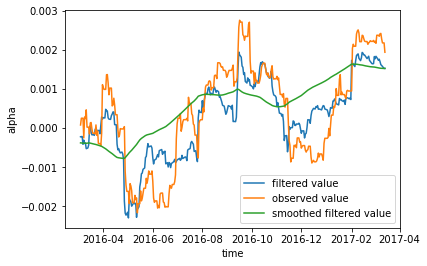

In [9]:
ii = pd.Index(data['Date']).get_loc(datetime(2016, 1, 1, 0, 0))
plt.plot(data_new['Date'][ii:],state_means[ii:],label="filtered value")
plt.plot(data_new['Date'][ii:],data_new['alpha'][ii:],label="observed value")
plt.plot(data_new['Date'][ii:],smoothed_state_means[ii:],label="smoothed filtered value")
plt.xlabel('time')
plt.ylabel('alpha')
plt.legend()
plt.show()

In [13]:
# use filter_update() to get the update info
update_predict = []
for i in xrange(1,len(data_new['Y_t'])):
    next_filtered_state_mean,_ = kf.filter_update(filtered_state_mean=state_means[i-1], 
                                                  filtered_state_covariance=filtered_state_covariances[i-1], 
                                                  observation=data_new['Y_t'][i-1])
    update_predict.append(next_filtered_state_mean)  
update_predict = list(np.array(update_predict).flatten())

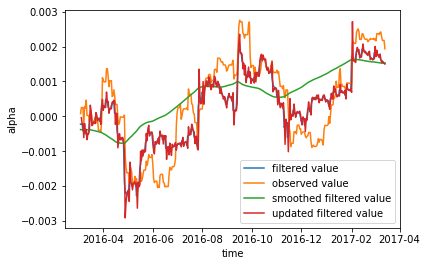

In [47]:
ii = pd.Index(data['Date']).get_loc(datetime(2016, 1, 1, 0, 0))
plt.plot(data_new['Date'][ii:],state_means[ii:],label="filtered value")
plt.plot(data_new['Date'][ii:],data_new['alpha'][ii:],label="observed value")
plt.plot(data_new['Date'][ii:],smoothed_state_means[ii:],label="smoothed filtered value")
plt.plot(data_new['Date'][ii+1:],update_predict[ii:],label="updated filtered value")
plt.xlabel('time')
plt.ylabel('alpha')
plt.legend()
plt.show()

Conclusion: Kalman filter succesfully captured the dynamics of observed data with updating information.